# Telecom Churn Prediction & Retention Analysis
  To predict customer churn using Machine Learning and identify key factors

In [2]:
import pandas as pd
import seaborn as sns
df1=pd.read_csv('telecom_churn_data.csv')
df1['tenure'] = df1['tenure'].replace(0, 1)
def tenure_group(t):
    if t <= 12:
        return 'New'
    elif t <= 48:
        return 'Mid'
    else:
        return 'Loyal'
df1['TenureGroup'] = df1['tenure'].apply(tenure_group)
service_cols = ['PhoneService', 'MultipleLines', 'OnlineSecurity', 'OnlineBackup',
                'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']
df1['ServiceCount'] = df1[service_cols].apply(lambda x: x.eq('Yes').sum(), axis=1)
contract_map = {
    'Month-to-month': 3,
    'One year': 2,
    'Two year': 1
}
df1['ContractRisk'] = df1['Contract'].map(contract_map)
df1['Churn'] = df1['Churn'].map({'Yes': 1, 'No': 0})
print("Feature Engineering Complete. Preview:")
print(df1[['tenure', 'TenureGroup', 'ServiceCount', 'Contract', 'ContractRisk', 'Churn']].head())

Feature Engineering Complete. Preview:
   tenure TenureGroup  ServiceCount        Contract  ContractRisk  Churn
0       1         New             1  Month-to-month             3      0
1      34         Mid             3        One year             2      0
2       2         New             3  Month-to-month             3      1
3      45         Mid             3        One year             2      0
4       2         New             1  Month-to-month             3      1


We analyzed churn rates across different contract types. As expected, Month-to-Month customers show a significantly higher risk of leaving compared to those on 1- or 2-year contracts.

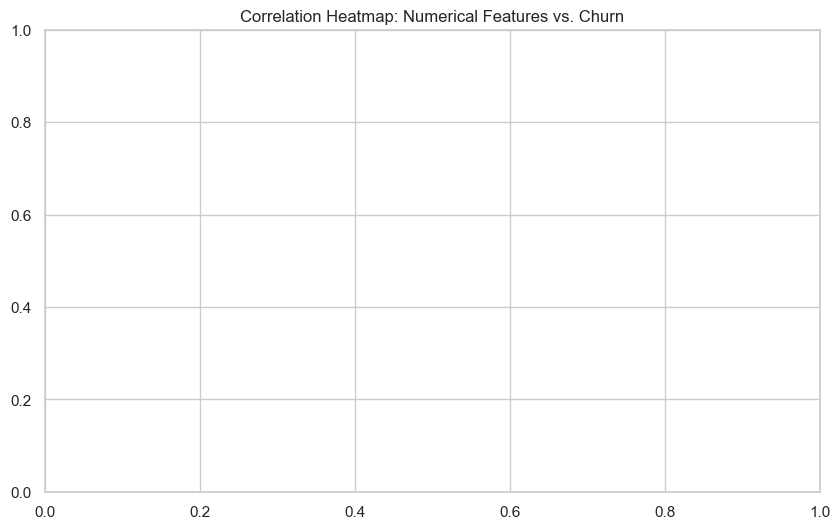

C:\Users\pokem\AppData\Local\Temp\ipykernel_8952\864845614.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Contract', y='ChurnNum', data=contract_churn,hue=None ,palette='Blues_d')


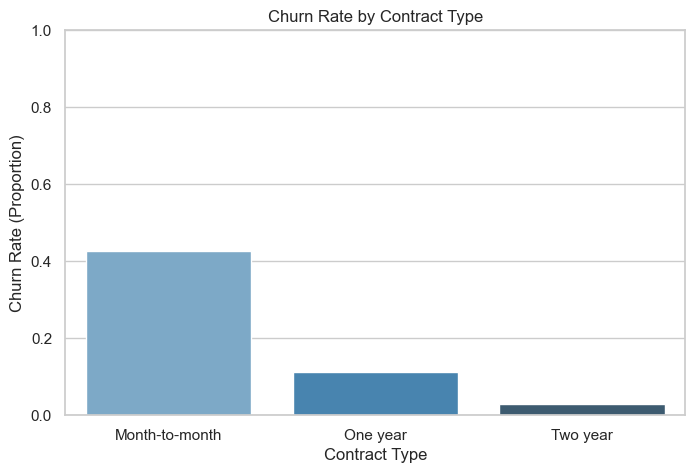

C:\Users\pokem\AppData\Local\Temp\ipykernel_8952\864845614.py:19: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df1[df1['Churn'] == 'Yes']['MonthlyCharges'], color='red', shade=True, label='Churned')
C:\Users\pokem\AppData\Local\Temp\ipykernel_8952\864845614.py:20: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df1[df1['Churn'] == 'No']['MonthlyCharges'], color='green', shade=True, label='Retained')


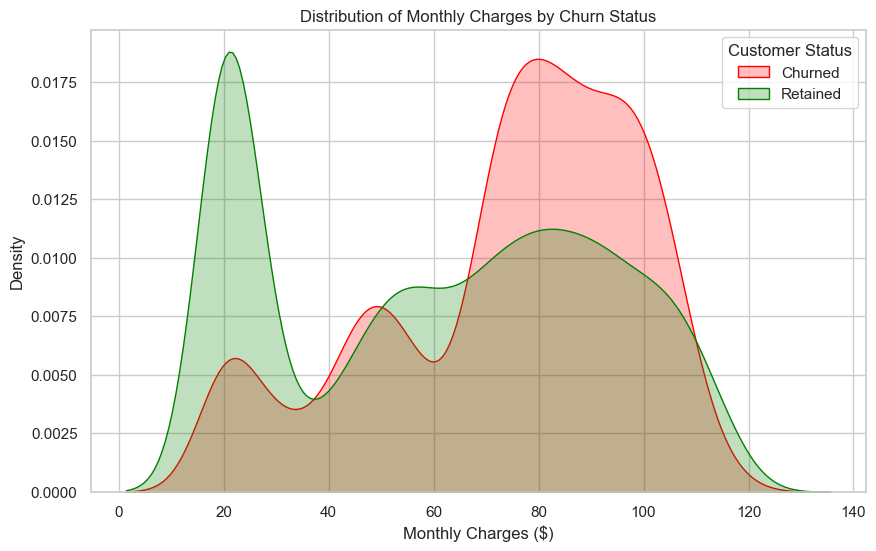

In [7]:
import matplotlib.pyplot as plt
df1 = pd.read_csv('telecom_churn_data.csv')
df1['ChurnNum'] = df1['Churn'].map({'Yes': 1, 'No': 0})
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
numeric_cols = ['tenure', 'MonthlyCharges', 'TotalCharges', 'ChurnNum']
heatmap_corr = df1[numeric_cols].corr()
plt.title('Correlation Heatmap: Numerical Features vs. Churn')
plt.show()
plt.figure(figsize=(8, 5))
contract_churn = df1.groupby('Contract')['ChurnNum'].mean().reset_index()
sns.barplot(x='Contract', y='ChurnNum', data=contract_churn,hue=None ,palette='Blues_d')
plt.title('Churn Rate by Contract Type')
plt.ylabel('Churn Rate (Proportion)')
plt.xlabel('Contract Type')
plt.ylim(0, 1)
plt.show()
plt.figure(figsize=(10, 6))
sns.kdeplot(df1[df1['Churn'] == 'Yes']['MonthlyCharges'], color='red', shade=True, label='Churned')
sns.kdeplot(df1[df1['Churn'] == 'No']['MonthlyCharges'], color='green', shade=True, label='Retained')
plt.title('Distribution of Monthly Charges by Churn Status')
plt.xlabel('Monthly Charges ($)')
plt.ylabel('Density')
plt.legend(title='Customer Status')
plt.show()

Since churn is a imbalanced class, we used Class Weights to penalize the model for missing churners. We compared Logistic Regression and Random Forest.

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, recall_score, f1_score, confusion_matrix
df1 = pd.read_csv('telecom_churn_data.csv')
df1['tenure'] = df1['tenure'].replace(0, 1)
df1['TenureGroup'] = df1['tenure'].apply(lambda t: 'New' if t <= 12 else ('Mid' if t <= 48 else 'Loyal'))
service_cols = ['PhoneService', 'MultipleLines', 'OnlineSecurity', 'OnlineBackup',
                'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']
df1['ServiceCount'] = df1[service_cols].apply(lambda x: x.eq('Yes').sum(), axis=1)
df1['ContractRisk'] = df1['Contract'].map({'Month-to-month': 3, 'One year': 2, 'Two year': 1})
df1['Churn'] = df1['Churn'].map({'Yes': 1, 'No': 0})
X = df1.drop(['customerID', 'Churn'], axis=1)
y = df1['Churn']
cat_cols = ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
            'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
            'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
            'PaperlessBilling', 'PaymentMethod', 'TenureGroup']
num_cols = ['tenure', 'MonthlyCharges', 'TotalCharges', 'ServiceCount', 'ContractRisk']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
ohe = OneHotEncoder(handle_unknown='ignore', drop='first')
scaler = StandardScaler()
X_train_cat_sparse = ohe.fit_transform(X_train[cat_cols])
X_test_cat_sparse = ohe.transform(X_test[cat_cols])
X_train_cat = pd.DataFrame(X_train_cat_sparse.toarray(), columns=ohe.get_feature_names_out(cat_cols))
X_test_cat = pd.DataFrame(X_test_cat_sparse.toarray(), columns=ohe.get_feature_names_out(cat_cols))

X_train_num = pd.DataFrame(scaler.fit_transform(X_train[num_cols]), columns=num_cols)
X_test_num = pd.DataFrame(scaler.transform(X_test[num_cols]), columns=num_cols)

# Reset indices to match before concatenation
X_train_cat.reset_index(drop=True, inplace=True); X_train_num.reset_index(drop=True, inplace=True); y_train.reset_index(drop=True, inplace=True)
X_test_cat.reset_index(drop=True, inplace=True); X_test_num.reset_index(drop=True, inplace=True); y_test.reset_index(drop=True, inplace=True)
X_train_processed = pd.concat([X_train_num, X_train_cat], axis=1)
X_test_processed = pd.concat([X_test_num, X_test_cat], axis=1)
lr_model = LogisticRegression(class_weight='balanced', random_state=42, max_iter=1000)
lr_model.fit(X_train_processed, y_train)
rf_model = RandomForestClassifier(class_weight='balanced', random_state=42, n_estimators=100)
rf_model.fit(X_train_processed, y_train)
def print_metrics(model_name, model, X_test, y_test):
    y_pred = model.predict(X_test)
    print(f"{model_name}")
    print(f"Accuracy:  {accuracy_score(y_test, y_pred):.4f}")
    print(f"Recall:    {recall_score(y_test, y_pred):.4f} (Key Metric)")
    print(f"F1 Score:  {f1_score(y_test, y_pred):.4f}")
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

print_metrics("Logistic Regression", lr_model, X_test_processed, y_test)
print_metrics("Random Forest", rf_model, X_test_processed, y_test)

Logistic Regression
Accuracy:  0.7331
Recall:    0.7888 (Key Metric)
F1 Score:  0.6108
Confusion Matrix:
 [[738 297]
 [ 79 295]]
Random Forest
Accuracy:  0.7814
Recall:    0.4786 (Key Metric)
F1 Score:  0.5375
Confusion Matrix:
 [[922 113]
 [195 179]]


C:\Users\pokem\AppData\Local\Temp\ipykernel_8952\483952767.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Coefficient', y='Feature', data=coefs, palette='coolwarm')


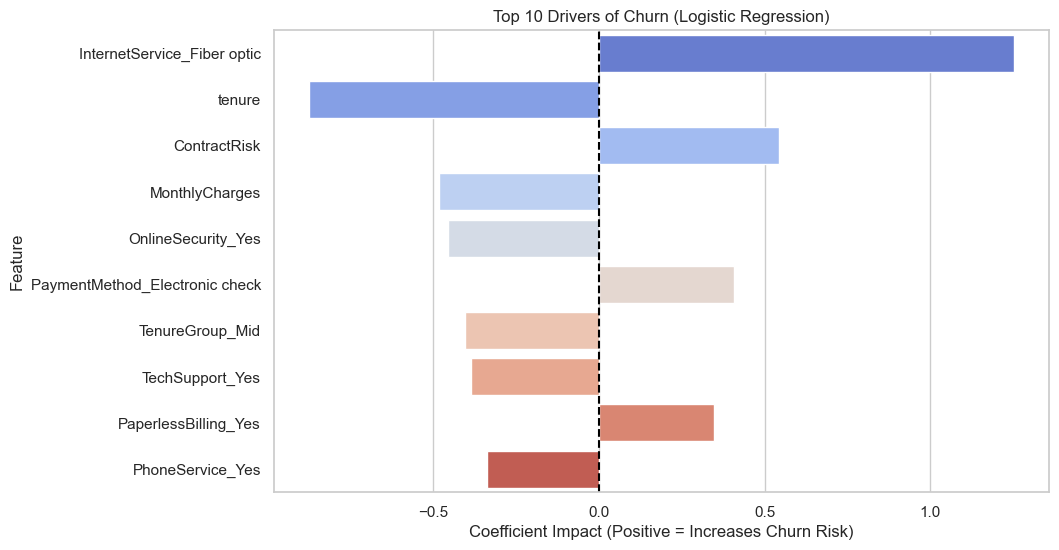

C:\Users\pokem\AppData\Local\Temp\ipykernel_8952\483952767.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importances, palette='viridis')


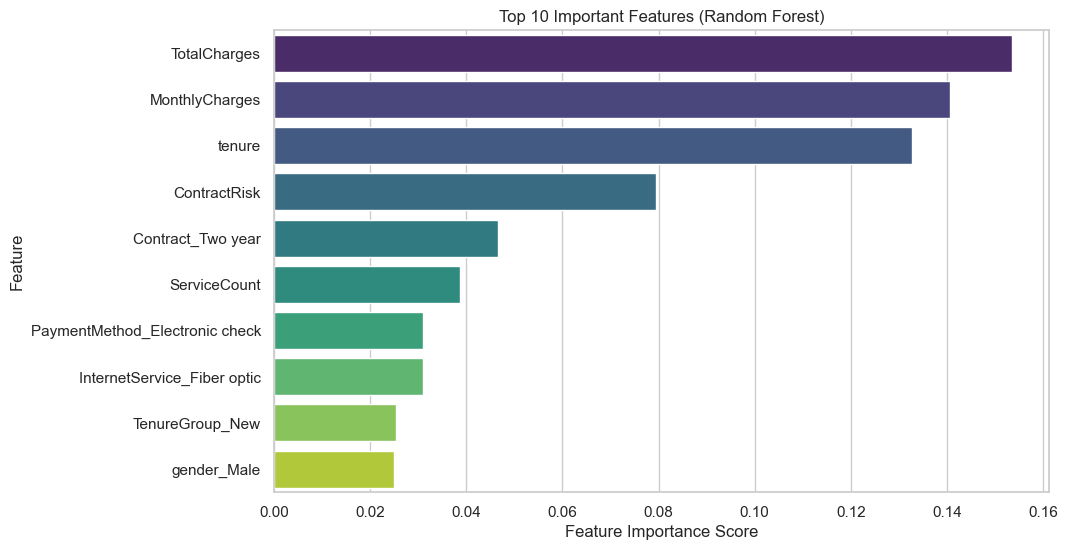

In [9]:
import matplotlib.pyplot as plt
feature_names = X_train_processed.columns
coefs = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': lr_model.coef_[0]
})
coefs['Abs_Coefficient'] = coefs['Coefficient'].abs()
coefs = coefs.sort_values(by='Abs_Coefficient', ascending=False).head(10)
plt.figure(figsize=(10, 6))
sns.barplot(x='Coefficient', y='Feature', data=coefs, palette='coolwarm')
plt.title('Top 10 Drivers of Churn (Logistic Regression)')
plt.xlabel('Coefficient Impact (Positive = Increases Churn Risk)')
plt.axvline(x=0, color='black', linestyle='--')
plt.show()
importances = pd.DataFrame({
    'Feature': feature_names,
    'Importance': rf_model.feature_importances_
})
importances = importances.sort_values(by='Importance', ascending=False).head(10)
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importances, palette='viridis')
plt.title('Top 10 Important Features (Random Forest)')
plt.xlabel('Feature Importance Score')
plt.show()

The model identified Month-to-Month contracts and High Monthly Charges as the top drivers of churn.
 We recommend offering a 5-10% discount to "Month-to-Month" customers if they switch to a 1-year contract.
 We selected Logistic Regression because it offers the high recall, ensuring we don't miss at-risk customers.